In [1]:
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#     sample=sample.select_dtypes(include='object')

# Deal with a single file
def dataWash(filename):
    sample=pd.read_csv(filename,header=[0,1],dtype=object)
    
    # Patterns stands for unknown
    washString=['**','(X)','-','+','N']
    
    # Column to deal with
    removeColumn=set()
    twoColumns=list(zip(*list(sample.columns)))
    secondColumn=twoColumns[1]
    firstColumn=twoColumns[0]
    
#     print(sample.shape)
#     print(len(firstColumn))
#     print(len(secondColumn),'\n')
    for wash in washString:
#         print("FOLLOWING IS COLUMN OF "+wash)
#         print("_______________________________")
        for column in sample.columns[3:]:
            if 'Margin of Error' in column[1]:
                removeColumn.add(column[1])
            else:
                temp=sample[sample[column].str.contains(wash,regex=False)]
                if temp.shape[0]!=0:
                    if temp.shape[0]>50:
                        removeColumn.add(column[1])
                    else:
                        sample[column]=sample[column].replace(wash,' ')


    return sample,list(removeColumn),secondColumn

def dataPreprocess():
    files=[]
    for i in range(10,17):
        files.append('2018_MCMProblemC_DATA/ACS_'+str(i)+'_5YR_DP02/ACS_'+str(i)+'_5YR_DP02_with_ann.csv')
    
    totalState=[]
    secondColumns=[]
    totalRemove=[]
    for filename in files:
        tempDf,tempRemove,secondColumn=dataWash(filename)
#     print(tempDf.shape)
        totalRemove.append(tempRemove)
        totalState.append(tempDf)
        secondColumns.append(secondColumn)
    
    totalRemove=list(totalRemove)
    return totalState,totalRemove,secondColumns


In [2]:
totalState,totalRemove,secondColumns=dataPreprocess()

In [3]:
def clearColumn(totalState,totalRemove,secondColumns):
    for i in range(len(totalState)):
        totalState[i].columns = totalState[i].columns.droplevel(0)
#         print('Initial shape',totalState[i].shape)
        totalState[i]=totalState[i].drop(totalRemove[i],axis=1)
#         print('Remove Count',len(totalRemove[i]))
#         print('After remove',totalState[i].shape,'\n')
        
        skip=[0,2]
        for j in range(totalState[i].shape[1]):
            if j not in skip:
                totalState[i].iloc[:,j]=pd.to_numeric(totalState[i].iloc[:,j],errors='coerce')
        
    return totalState
                
                
        
clearedDf=clearColumn(totalState,totalRemove,secondColumns)
print(clearedDf[0].iloc[0:5,0:5])

               Id    Id2                  Geography  \
0  0500000US21001  21001     Adair County, Kentucky   
1  0500000US21003  21003     Allen County, Kentucky   
2  0500000US21005  21005  Anderson County, Kentucky   
3  0500000US21007  21007   Ballard County, Kentucky   
4  0500000US21009  21009    Barren County, Kentucky   

  Estimate; HOUSEHOLDS BY TYPE - Total households  \
0                                            7272   
1                                            7811   
2                                            8319   
3                                            3363   
4                                           16727   

  Percent; HOUSEHOLDS BY TYPE - Total households  
0                                           7272  
1                                           7811  
2                                           8319  
3                                           3363  
4                                          16727  


In [4]:
def df_column_uniquify(df):
    df_columns = df.columns
    new_columns = []
    for item in df_columns:
        counter = 0
        newitem = item
        while newitem in new_columns:
            counter += 1
            newitem = "{}_{}".format(item, counter)
        new_columns.append(newitem)
    df.columns = new_columns
    return df

from scipy import stats

# stats.pearsonr(df['GDP ($ per capita)'], df['Phones (per 1000)'])

def joinDrugFactor(clearedDf):
    res=[]
    for i in range(2010,2017):
        df = pd.read_csv('2018_MCMProblemC_DATA/MCM_NFLIS_Data.csv')
        df = df[(df['YYYY']==i)]
        df=df.drop_duplicates(subset=['FIPS_Combined', 'TotalDrugReportsCounty'], keep='first')
        df=df[['YYYY','FIPS_Combined','TotalDrugReportsCounty']]
        df=df.rename(columns={'FIPS_Combined':'Id2'})
        df=df.sort_values('Id2')

        temp=pd.concat([df.set_index('Id2'),clearedDf[i-2010].set_index('Id2')], axis=1, join='inner').reset_index()
        temp=temp.sort_values('Id2')
        temp=temp.drop(['Id','Geography'],axis=1)

        temp=temp.fillna(temp.mean())
        temp=df_column_uniquify(temp)
        print(temp.shape)
        res.append(temp)
    return res
        
    
totalDf=joinDrugFactor(clearedDf)
print(totalDf[0].iloc[0:5,0:5])

/home/wayne/anaconda3/envs/tf-night/lib/python3.6/site-packages/pandas/core/generic.py:6120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/wayne/anaconda3/envs/tf-night/lib/python3.6/site-packages/pandas/core/frame.py:4024: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


(445, 276)
(427, 276)
(431, 292)
(447, 292)
(440, 292)
(424, 292)
(437, 292)
     Id2  YYYY  TotalDrugReportsCounty  \
0  21001  2010                      88   
1  21003  2010                     168   
2  21005  2010                      98   
3  21007  2010                      24   
4  21009  2010                     383   

  Estimate; HOUSEHOLDS BY TYPE - Total households  \
0                                            7272   
1                                            7811   
2                                            8319   
3                                            3363   
4                                           16727   

  Percent; HOUSEHOLDS BY TYPE - Total households  
0                                           7272  
1                                           7811  
2                                           8319  
3                                           3363  
4                                          16727  


In [5]:
# stats.shapiro(totalDf[1]['TotalDrugReportsCounty'])
def normalCheck(totalDf):
    for year in range(len(totalDf)):
        totalDf[year]=totalDf[year].fillna(totalDf[year].mean())
        print(stats.shapiro(totalDf[year]['TotalDrugReportsCounty']))
    return totalDf

totalDf=normalCheck(totalDf)
print(totalDf[0].iloc[0:5,0:5])

(0.20795756578445435, 1.554746251362242e-39)
(0.2545713186264038, 4.508662955201377e-38)
(0.24557173252105713, 2.236669651886185e-38)
(0.2769763469696045, 2.2915551496174737e-38)
(0.30265820026397705, 1.221586308326368e-37)
(0.28928565979003906, 2.4939052262551516e-37)
(0.2718256115913391, 4.100763469376152e-38)
     Id2  YYYY  TotalDrugReportsCounty  \
0  21001  2010                      88   
1  21003  2010                     168   
2  21005  2010                      98   
3  21007  2010                      24   
4  21009  2010                     383   

   Estimate; HOUSEHOLDS BY TYPE - Total households  \
0                                             7272   
1                                             7811   
2                                             8319   
3                                             3363   
4                                            16727   

   Percent; HOUSEHOLDS BY TYPE - Total households  
0                                            7272  
1   

In [6]:
def forceCommonSize(totalDf):
    commonCols=set(totalDf[-1].columns)
    commonRows=set(totalDf[-1]['Id2'])
    for i in range(len(totalDf)-1):
        commonCols=commonCols.intersection(set(totalDf[i].columns))
        commonRows=commonRows.intersection(set(totalDf[i]['Id2']))
    commonCols=list(commonCols)
    commonRows=list(commonRows)
    for i in range(len(totalDf)):
        temp=totalDf[i][commonCols]
        temp=temp[temp['Id2'].isin(commonRows)]
        print(temp.shape)
        totalDf[i]=temp
    return totalDf
totalDf=forceCommonSize(totalDf)    
print(totalDf[0].shape)

(391, 49)
(391, 49)
(391, 49)
(391, 49)
(391, 49)
(391, 49)
(391, 49)
(391, 49)


In [7]:
def spearmanr(totalDf):
    res=[]
    for temp in totalDf:
        rp=[]
        cols=temp.columns
        for k in range(len(cols)): 
            if cols[k] not in ['Id2','YYYY','TotalDrugReportsCounty']:
                r,pvalue=stats.spearmanr(temp['TotalDrugReportsCounty'],temp[cols[k]])
                if pvalue<0.05 and abs(r)>=0.4:
                    rp.append((cols[k],r,pvalue))
        rp=sorted(rp, reverse=True,key=lambda tup: abs(tup[1]))
        print(len(rp))
        for j in range(min(5,len(rp))):
            print(rp[j][0],"{0:.2f}".format(rp[j][1]),"{0:.2f}".format(rp[j][2]))
        print(rp[0:5])
        rp=rp[30:]
        res.append(rp)
    return res
totalSpear=spearmanr(totalDf)

42
Estimate; VETERAN STATUS - Civilian population 18 years and over 0.83 0.00
Percent; VETERAN STATUS - Civilian population 18 years and over 0.83 0.00
Percent; MARITAL STATUS - Males 15 years and over 0.83 0.00
Estimate; MARITAL STATUS - Males 15 years and over 0.83 0.00
Estimate; MARITAL STATUS - Females 15 years and over 0.83 0.00
[('Estimate; VETERAN STATUS - Civilian population 18 years and over', 0.8302308000864903, 8.952290338409414e-101), ('Percent; VETERAN STATUS - Civilian population 18 years and over', 0.8302308000864903, 8.952290338409414e-101), ('Percent; MARITAL STATUS - Males 15 years and over', 0.8296194798400303, 1.689097448831135e-100), ('Estimate; MARITAL STATUS - Males 15 years and over', 0.8296194798400303, 1.689097448831135e-100), ('Estimate; MARITAL STATUS - Females 15 years and over', 0.8291205117095276, 2.830665028746994e-100)]
42
Estimate; VETERAN STATUS - Civilian population 18 years and over 0.78 0.00
Percent; VETERAN STATUS - Civilian population 18 years an

/home/wayne/anaconda3/envs/tf-night/lib/python3.6/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


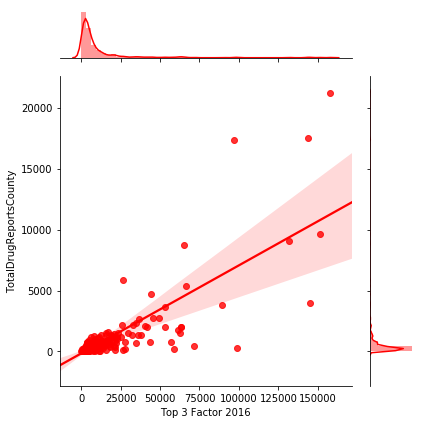

In [248]:
import seaborn as sns
import matplotlib.pyplot as plt

i=2
h=sns.jointplot(x=totalSpear[-1][i][0], y='TotalDrugReportsCounty', data=totalDf[-1],color='r',kind='reg')
h.ax_joint.set_xlabel('Top '+str(i+1)+ " Factor 2016")
# h.ax_joint.set_yticks(np.linspace(0,5000,num=5))
# h.ax_joint.set_xticks(np.linspace(0,15000,num=5))
plt.tight_layout()
plt.savefig('Top '+str(i+1)+'Factor.png',dpi=500)
plt.show()

In [8]:
def commonFactor(totalDf,totalSpear):
    comFac=set()
    for i in range(len(totalSpear)):
        for j in range(len(totalSpear[i])):
            comFac.add(totalSpear[i][j][0])
    comFac=list(comFac)+['Id2','YYYY','TotalDrugReportsCounty']
    for i in range(len(totalDf)):
        temp=totalDf[i][comFac]
        print(temp.shape)
        totalDf[i]=temp
    return totalDf
totalDf=commonFactor(totalDf,totalSpear)

(391, 15)
(391, 15)
(391, 15)
(391, 15)
(391, 15)
(391, 15)
(391, 15)


In [9]:
def addGeo(totalDf):
    for i in range(len(totalDf)):
        temp=totalDf[i]
        print(temp.shape)
        temp=temp.assign(Geo1=lambda x: x['Id2']//1000)
        temp=temp.assign(Geo2=lambda x: x['Id2']%1000)
        totalDf[i]=temp
    return totalDf
        
totalDf=addGeo(totalDf)

(391, 15)
(391, 15)
(391, 15)
(391, 15)
(391, 15)
(391, 15)
(391, 15)


In [10]:
def rearrange(totalDf):
    sameDf=[]
    for i in range(len(totalDf)):
        temp=totalDf[i].reindex(sorted(totalDf[i].columns),axis=1)
        temp=temp.sort_values('Id2')
        
        id2=temp['Id2']
        temp=temp.drop(labels=['Id2'],axis=1)
        temp.insert(0,'Id2',id2)
        
        YYYY=temp['YYYY']
        temp=temp.drop(labels=['YYYY'],axis=1)
        temp.insert(1,'YYYY',YYYY)
        
        TotalDrugReportsCounty=temp['TotalDrugReportsCounty']
        temp=temp.drop(labels=['TotalDrugReportsCounty'],axis=1)
        temp.insert(2,'TotalDrugReportsCounty',TotalDrugReportsCounty)
#         print(temp.iloc[0:5,0:5])
        sameDf.append(temp)
    return sameDf
sameDf=rearrange(totalDf)

In [11]:
def getMinMax():
    allMax=[]
    allMin=[]
    
    mean=[]
    var=[]
    for i in range(sameDf[0].shape[1]):
        temp=pd.Series()
        for j in range(len(sameDf)):
            temp=temp.append(sameDf[j].iloc[:,i])
        mean.append(temp.mean())
        var.append(temp.std())
    
    
    for i in range(len(sameDf)):
        tempMax=sameDf[i].max(axis=0)
        tempMin=sameDf[i].min(axis=0)
        allMax.append(tempMax)
        allMin.append(tempMin)
    
    
    
    globalMax=[]
    globalMin=[]
    
    for i in range(sameDf[0].shape[1]):
        tempMax=allMax[-1][i]
        tempMin=allMin[-1][i]
        for j in range(len(allMax)-1):
            tempMax=max(allMax[j][i],tempMax)
            tempMin=min(allMin[j][i],tempMin)
        globalMax.append(tempMax)
        globalMin.append(tempMin)
    
    return globalMax,globalMin,mean,var

globalMax,globalMin,mean,var=getMinMax()
print(var)

[12160.885479905348, 2.000365463685097, 1811.8616244568716, 22540.758084416444, 22540.728687806164, 22540.758084416444, 3798.2809815336377, 25754.69109483285, 12.16067707407719, 115.70986899374172, 9.235934316352457, 7.061245959914347, 22540.758084416444, 22540.728687806164, 22540.758084416444, 3798.2809815336377, 25754.69109483285]


In [73]:
print(globalMax)

[54107.0, 2016.0, 33513.0, 1559938.0, 1035252.0, 22706.0, 43688.0, 17090.0, 155330.0, 166077.0, 582594.0, 1452064.0, 679054.0, 589386.0, 1559938.0, 1509742.0, 1537901.0, 425140.0, 343360.0, 343360.0, 343360.0, 56932.0, 372184.0, 54.0, 840.0, 1559938.0, 73.7, 96.6, 1035252.0, 22706.0, 43688.0, 17090.0, 582594.0, 1452064.0, 679054.0, 589386.0, 1559938.0, 1509742.0, 1537901.0, 425140.0, 343360.0, 343360.0, 343360.0, 56932.0, 372184.0]


In [12]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


def getValues(fips_code):
    yearList=[]
    for i in range(len(sameDf)):
        
        yearList.append(np.array(sameDf[i][sameDf[i]['Id2']==fips_code].values[0][2:]))
    values=np.vstack(yearList)
    values = values.astype('float32')
# normalize features
#     scaler = MinMaxScaler(feature_range=(0, 1))
#     scaled = scaler.fit_transform(values)
    
#     for col in range(values.shape[1]):
#         values[:,col]=(values[:,col]-globalMin[col+2])/(globalMax[col+2]-globalMin[col+2])*100

    for col in range(values.shape[1]):
        values[:,col]=(values[:,col]-mean[col+2])/var[col+2]
        
        
#     print(values)
    # frame as supervised learning
    reframed = series_to_supervised(values, 1, 1)
#     reframed.drop(['Geo1','Geo2'],axis=1,inplace=True)
    return reframed.values
    # drop columns we don't want to predict
#     reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
#     print(reframed.iloc[0:5,8:16])
    

Using TensorFlow backend.


In [75]:
getValues(42075)

array([[ 0.02157505,  0.20654166,  0.21622367,  0.24457794,  0.06499682,
        -0.11930924,  0.29452083,  0.22179134,  0.2109738 ,  0.20512864,
         0.20124727,  0.20292072,  0.20654166,  0.20555241,  0.20558444,
         0.13162641, -0.07452457, -0.07452365, -0.07452457,  0.75242937,
         0.04574305,  0.27067253, -0.27883038,  0.20654166, -0.05587708,
         0.16129541,  0.21622367,  0.24457794,  0.06499682, -0.11930924,
         0.2109738 ,  0.20512864,  0.20124727,  0.20292072,  0.20654166,
         0.20555241,  0.20558444,  0.13162641, -0.07452457, -0.07452365,
        -0.07452457,  0.75242937,  0.04574305,  0.14023754,  0.21333507,
         0.22381997,  0.25117078, -0.02742058, -0.16160938,  0.30191448,
         0.22428511,  0.21605368,  0.21180275,  0.20868462,  0.20940517,
         0.21333507,  0.21191056,  0.21242097,  0.13431685, -0.06924525,
        -0.06924432, -0.06924525,  0.807191  ,  0.05843977,  0.27067253,
        -0.27883038,  0.21333507, -0.01256782,  0.2

In [14]:
def getTrainFIPS():
    trainStates=[21,39,51,54] #42
    temp=sameDf[0][sameDf[0]['Geo1'].isin(trainStates)]
    trainCodes=temp['Id2']
    return trainCodes

trainCodes=getTrainFIPS()

In [15]:
test=getValues(42075)
test_X, test_y = test[:, :-1], test[:, -1]
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# design network
model = Sequential()
model.add(LSTM(64, input_shape=(test_X.shape[1], test_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = []
# plot history

for code in trainCodes:
    model.reset_states()
    train=getValues(code)
    train_X, train_y = train[:, :-1], train[:, -1]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    subHis=model.fit(train_X, train_y, epochs=2, batch_size=1, 
                     validation_data=(test_X, test_y), 
                     verbose=2, shuffle=False)
    history.append(subHis)

allHis={}
allHis['loss']=[]
allHis['val_loss']=[]

for subHis in history:
    allHis['loss']=allHis['loss']+subHis.history['loss']
    allHis['val_loss']=allHis['val_loss']+subHis.history['val_loss']
 

Train on 6 samples, validate on 6 samples
Epoch 1/2
 - 2s - loss: 0.0838 - val_loss: 0.0414
Epoch 2/2
 - 0s - loss: 0.0819 - val_loss: 0.0500
Train on 6 samples, validate on 6 samples
Epoch 1/2
 - 0s - loss: 0.0316 - val_loss: 0.0690
Epoch 2/2
 - 0s - loss: 0.0167 - val_loss: 0.0608
Train on 6 samples, validate on 6 samples
Epoch 1/2
 - 0s - loss: 0.0144 - val_loss: 0.0532
Epoch 2/2
 - 0s - loss: 0.0119 - val_loss: 0.0610
Train on 6 samples, validate on 6 samples
Epoch 1/2
 - 0s - loss: 0.0127 - val_loss: 0.0715
Epoch 2/2
 - 0s - loss: 0.0109 - val_loss: 0.0629
Train on 6 samples, validate on 6 samples
Epoch 1/2
 - 0s - loss: 0.0234 - val_loss: 0.0788
Epoch 2/2
 - 0s - loss: 0.0260 - val_loss: 0.0705
Train on 6 samples, validate on 6 samples
Epoch 1/2
 - 0s - loss: 0.0148 - val_loss: 0.0624
Epoch 2/2
 - 0s - loss: 0.0279 - val_loss: 0.0648
Train on 6 samples, validate on 6 samples
Epoch 1/2
 - 0s - loss: 0.0591 - val_loss: 0.0568
Epoch 2/2
 - 0s - loss: 0.0326 - val_loss: 0.0493
Train 

 - 0s - loss: 0.0059 - val_loss: 0.0374
Train on 6 samples, validate on 6 samples
Epoch 1/2
 - 0s - loss: 0.0158 - val_loss: 0.0399
Epoch 2/2
 - 0s - loss: 0.0101 - val_loss: 0.0351
Train on 6 samples, validate on 6 samples
Epoch 1/2
 - 0s - loss: 0.0203 - val_loss: 0.0391
Epoch 2/2
 - 0s - loss: 0.0076 - val_loss: 0.0328
Train on 6 samples, validate on 6 samples
Epoch 1/2
 - 0s - loss: 0.0024 - val_loss: 0.0322
Epoch 2/2
 - 0s - loss: 0.0071 - val_loss: 0.0338
Train on 6 samples, validate on 6 samples
Epoch 1/2
 - 0s - loss: 0.0020 - val_loss: 0.0316
Epoch 2/2
 - 0s - loss: 0.0056 - val_loss: 0.0306
Train on 6 samples, validate on 6 samples
Epoch 1/2
 - 0s - loss: 0.0127 - val_loss: 0.0297
Epoch 2/2
 - 0s - loss: 0.0041 - val_loss: 0.0335
Train on 6 samples, validate on 6 samples
Epoch 1/2
 - 0s - loss: 0.0036 - val_loss: 0.0343
Epoch 2/2
 - 0s - loss: 0.0026 - val_loss: 0.0331
Train on 6 samples, validate on 6 samples
Epoch 1/2
 - 0s - loss: 0.0015 - val_loss: 0.0340
Epoch 2/2
 - 0s 

Epoch 2/2
 - 0s - loss: 0.0043 - val_loss: 0.0698
Train on 6 samples, validate on 6 samples
Epoch 1/2
 - 0s - loss: 0.0341 - val_loss: 0.0729
Epoch 2/2
 - 0s - loss: 0.0140 - val_loss: 0.0790
Train on 6 samples, validate on 6 samples
Epoch 1/2
 - 0s - loss: 0.0091 - val_loss: 0.0808
Epoch 2/2
 - 0s - loss: 0.0031 - val_loss: 0.0781
Train on 6 samples, validate on 6 samples
Epoch 1/2
 - 0s - loss: 0.0443 - val_loss: 0.0406
Epoch 2/2
 - 0s - loss: 0.0642 - val_loss: 0.0546
Train on 6 samples, validate on 6 samples
Epoch 1/2
 - 0s - loss: 0.0169 - val_loss: 0.0871
Epoch 2/2
 - 0s - loss: 0.0046 - val_loss: 0.0940
Train on 6 samples, validate on 6 samples
Epoch 1/2
 - 0s - loss: 0.0233 - val_loss: 0.1025
Epoch 2/2
 - 0s - loss: 0.0058 - val_loss: 0.1115
Train on 6 samples, validate on 6 samples
Epoch 1/2
 - 0s - loss: 0.0180 - val_loss: 0.1157
Epoch 2/2
 - 0s - loss: 0.0158 - val_loss: 0.1172
Train on 6 samples, validate on 6 samples
Epoch 1/2
 - 0s - loss: 0.0371 - val_loss: 0.1076
Epoch 

 - 0s - loss: 0.0052 - val_loss: 0.0899
Epoch 2/2
 - 0s - loss: 0.0034 - val_loss: 0.0919
Train on 6 samples, validate on 6 samples
Epoch 1/2
 - 0s - loss: 0.0214 - val_loss: 0.0856
Epoch 2/2
 - 0s - loss: 0.0091 - val_loss: 0.0775
Train on 6 samples, validate on 6 samples
Epoch 1/2
 - 0s - loss: 0.0357 - val_loss: 0.0715
Epoch 2/2
 - 0s - loss: 0.0075 - val_loss: 0.0628
Train on 6 samples, validate on 6 samples
Epoch 1/2
 - 0s - loss: 0.0088 - val_loss: 0.0653
Epoch 2/2
 - 0s - loss: 0.0087 - val_loss: 0.0602
Train on 6 samples, validate on 6 samples
Epoch 1/2
 - 0s - loss: 0.0048 - val_loss: 0.0560
Epoch 2/2
 - 0s - loss: 0.0078 - val_loss: 0.0550
Train on 6 samples, validate on 6 samples
Epoch 1/2
 - 0s - loss: 0.0077 - val_loss: 0.0543
Epoch 2/2
 - 0s - loss: 0.0066 - val_loss: 0.0524
Train on 6 samples, validate on 6 samples
Epoch 1/2
 - 0s - loss: 0.0090 - val_loss: 0.0476
Epoch 2/2
 - 0s - loss: 0.0130 - val_loss: 0.0474
Train on 6 samples, validate on 6 samples
Epoch 1/2
 - 0s 

 - 0s - loss: 0.0153 - val_loss: 0.0475
Epoch 2/2
 - 0s - loss: 0.0031 - val_loss: 0.0489
Train on 6 samples, validate on 6 samples
Epoch 1/2
 - 0s - loss: 0.0087 - val_loss: 0.0457
Epoch 2/2
 - 0s - loss: 0.0107 - val_loss: 0.0510
Train on 6 samples, validate on 6 samples
Epoch 1/2
 - 0s - loss: 0.0026 - val_loss: 0.0508
Epoch 2/2
 - 0s - loss: 0.0062 - val_loss: 0.0493
Train on 6 samples, validate on 6 samples
Epoch 1/2
 - 0s - loss: 0.0039 - val_loss: 0.0485
Epoch 2/2
 - 0s - loss: 0.0035 - val_loss: 0.0475
Train on 6 samples, validate on 6 samples
Epoch 1/2
 - 0s - loss: 0.0075 - val_loss: 0.0425
Epoch 2/2
 - 0s - loss: 0.0087 - val_loss: 0.0442
Train on 6 samples, validate on 6 samples
Epoch 1/2
 - 0s - loss: 0.0144 - val_loss: 0.0451
Epoch 2/2
 - 0s - loss: 0.0029 - val_loss: 0.0402
Train on 6 samples, validate on 6 samples
Epoch 1/2
 - 0s - loss: 0.4223 - val_loss: 0.0788
Epoch 2/2
 - 0s - loss: 0.2338 - val_loss: 0.0840
Train on 6 samples, validate on 6 samples
Epoch 1/2
 - 0s 

 - 0s - loss: 0.0408 - val_loss: 0.0314
Epoch 2/2
 - 0s - loss: 0.0172 - val_loss: 0.0342
Train on 6 samples, validate on 6 samples
Epoch 1/2
 - 0s - loss: 0.0479 - val_loss: 0.0358
Epoch 2/2
 - 0s - loss: 0.0283 - val_loss: 0.0360
Train on 6 samples, validate on 6 samples
Epoch 1/2
 - 0s - loss: 0.0833 - val_loss: 0.0311
Epoch 2/2
 - 0s - loss: 0.0476 - val_loss: 0.0282
Train on 6 samples, validate on 6 samples
Epoch 1/2
 - 0s - loss: 0.1741 - val_loss: 0.0101
Epoch 2/2
 - 0s - loss: 0.0584 - val_loss: 0.0101
Train on 6 samples, validate on 6 samples
Epoch 1/2
 - 0s - loss: 0.0372 - val_loss: 0.0203
Epoch 2/2
 - 0s - loss: 0.0112 - val_loss: 0.0390
Train on 6 samples, validate on 6 samples
Epoch 1/2
 - 0s - loss: 0.0782 - val_loss: 0.0495
Epoch 2/2
 - 0s - loss: 0.0220 - val_loss: 0.0606
Train on 6 samples, validate on 6 samples
Epoch 1/2
 - 0s - loss: 0.0370 - val_loss: 0.0634
Epoch 2/2
 - 0s - loss: 0.0250 - val_loss: 0.0603
Train on 6 samples, validate on 6 samples
Epoch 1/2
 - 0s 

In [113]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0,1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0,1


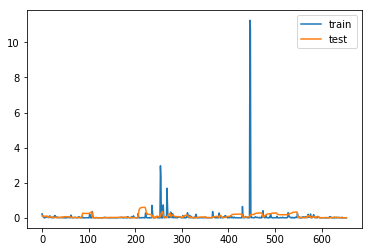

In [45]:
import matplotlib.pyplot as pyplot
pyplot.plot(allHis['loss'], label='train')
pyplot.plot(allHis['val_loss'], label='test')
pyplot.legend()
pyplot.savefig(fname="BadTrain.png",dpi=500)
pyplot.show()

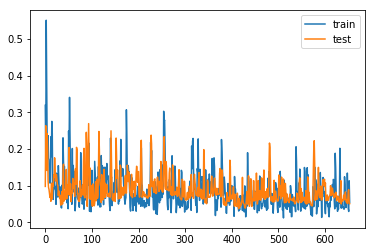

In [120]:
  
pyplot.plot(allHis['loss'], label='train')
pyplot.plot(allHis['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [16]:
def getTestFIPS():
    trainStates=[42] #42
    temp=sameDf[0][sameDf[0]['Geo1'].isin(trainStates)]
    trainCodes=temp['Id2']
    return trainCodes

testCodes=getTestFIPS()

In [17]:
result=[]
mse=[]
print(var[2])
print(mean[2])
for code in testCodes:
    
    test=getValues(code)
    test_X, test_y = test[:, :-1], test[:, -1]
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    yhat = model.predict(test_X)
    
    inv_yhat=yhat*var[2]+mean[2]
    inv_y=test_y*var[2]+mean[2]
    
#     inv_yhat=yhat*(globalMax[2]-globalMin[2])+globalMin[2]
#     inv_y=test_y*(globalMax[2]-globalMin[2])+globalMin[2]
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
#     print(inv_y)
#     print(inv_yhat.flatten())
    result.append(inv_yhat.flatten().tolist())
    mse.append(rmse)
print(mse)

1811.8616244568716
608.909024479357
[54.518383600310685, 206.5370634867989, 4.293429238055797, 57.9446905091668, 9.385069868572545, 918.9049189116358, 29.29581143902817, 17.41892491838977, 629.1858082077185, 113.18901848788158, 28.782967680828623, 20.200094634485936, 191.19130022375495, 466.9613708595177, 17.435466251248847, 20.133635569613354, 14.258023864015517, 39.60293802478943, 26.324073547696436, 26.608226955195995, 205.7627578061686, 542.0319697674668, 4.151064743048049, 32.88377489533687, 6.565458375685686, 19.987710610258823, 11.583122050236026, 8.750996124242308, 3.305138956169965, 42.55191710621347, 4.445215100124734, 5.155694180210692, 45.61248490596489, 941.6319941994325, 27.667784273792034, 70.87930914479733, 1127.005545682895, 222.47440161735463, 32.57930341094155, 10.681794723986725, 35.505193625919894, 4.667145545548688, 288.20473408672524, 217.79412583905932, 48.47191569690768, 608.7789777497248, 12.840291766598108, 11.249418455563777, 8512.201125443407, 57.5549181522

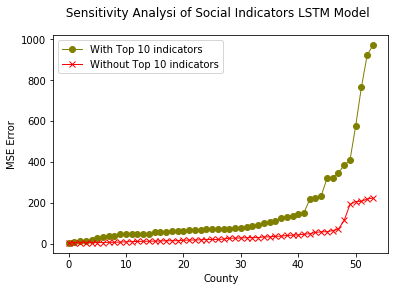

In [23]:

fig=plt.figure()

mse1=[47.278885020165184, 2002.796856897873, 62.63237348994827, 71.95970552156255, 69.50036181897724, 132.6399393682951, 98.88331092599752, 85.22641891144289, 984.4117215372844, 151.34733438352987, 9.79637229883007, 142.9060894105811, 384.15798751945795, 406.3263582085218, 45.27102897497609, 105.68332801493574, 66.57630065266281, 92.52074830646097, 27.379677290202398, 1065.2787780670371, 1228.0994971906796, 921.220521916441, 32.9385840221284, 1178.953985531242, 111.83657248553578, 222.6536337565592, 10.958101412756939, 45.84312957572678, 76.70748708058915, 46.48472426339377, 56.7533447355473, 59.5785757588508, 765.0104165957481, 345.900105250779, 80.07244949399731, 322.6989091049116, 575.3452767686548, 1281.6834144982918, 73.04561329124255, 69.58325302515325, 54.37997462876385, 67.69455468776643, 318.3370364095262, 3124.5404462096503, 10.444021414808967, 969.6012066824175, 34.89321390977227, 69.94315144167976, 13979.262927636779, 233.3560098727907, 5.210467315919806, 77.17963016560782, 63.028174503550396, 46.776070083129845, 64.13968292548108, 39.15813137688885, 126.63499852553598, 56.70648972174614, 44.62857374739375, 216.26146104021862, 128.98083826919796, 1356.8282868513613, 17.42326490391825, 1183.080724211159]
mse3=[169.88580148698418, 686.9505076786828, 31.782978382205624, 290.97481635014395, 20.17624901139758, 1920.7173790019187, 283.67958928164006, 40.756702082583146, 438.3922152308364, 154.65092370601928, 254.28809172619546, 97.77422873481284, 14.975991936184268, 969.863166895207, 6.56650529976232, 119.21169703908043, 27.772975998275395, 41.58626112381122, 40.33535719488626, 837.1384294129615, 1896.9259342420305, 508.9800462690065, 8.774526608296714, 1391.6768213202374, 312.8168019184711, 173.81387652277652, 7.88721499646045, 14.444132020620055, 44.98891329356531, 42.508086029950675, 28.291804617169504, 33.69926199175677, 551.7544743814951, 1814.7725064040396, 80.31658549919811, 142.07442619319283, 1461.1120764677842, 2081.6636375745243, 195.58446065574842, 41.37204365382196, 161.77675590145822, 23.963720239047035, 225.92850085812546, 1610.5995001861884, 40.65676492515959, 2172.845139442754, 78.86733879690787, 32.3689364495499, 12245.765308873104, 154.66273160291396, 7.571488768345988, 332.9365203195648, 26.690418092805327, 23.32022089596749, 31.736539615675554, 7.729946895678506, 63.017196003848824, 19.096566000404692, 16.379897921177747, 121.01092328665004, 69.97102148501371, 1987.6332030835065, 5.3512151675036295, 2422.2266615657586]
mse4=[54.518383600310685, 206.5370634867989, 4.293429238055797, 57.9446905091668, 9.385069868572545, 918.9049189116358, 29.29581143902817, 17.41892491838977, 629.1858082077185, 113.18901848788158, 28.782967680828623, 20.200094634485936, 191.19130022375495, 466.9613708595177, 17.435466251248847, 20.133635569613354, 14.258023864015517, 39.60293802478943, 26.324073547696436, 26.608226955195995, 205.7627578061686, 542.0319697674668, 4.151064743048049, 32.88377489533687, 6.565458375685686, 19.987710610258823, 11.583122050236026, 8.750996124242308, 3.305138956169965, 42.55191710621347, 4.445215100124734, 5.155694180210692, 45.61248490596489, 941.6319941994325, 27.667784273792034, 70.87930914479733, 1127.005545682895, 222.47440161735463, 32.57930341094155, 10.681794723986725, 35.505193625919894, 4.667145545548688, 288.20473408672524, 217.79412583905932, 48.47191569690768, 608.7789777497248, 12.840291766598108, 11.249418455563777, 8512.201125443407, 57.55491815227978, 4.594135501801305, 7.246240101284855, 18.442326731820014, 12.119954425990468, 13.94664570395339, 22.151930114834236, 41.28809054556093, 6.527330892791047, 16.09556270131228, 63.641449785963985, 29.307077390218392, 36.47562629313666, 13.992730024204478, 384.0632882416647]
mse2=[112.45410956391278, 1051.5583079411242, 8.446456563494772, 46.04440950304798, 9.629067094244839, 2617.5167621239793, 48.94329916549481, 30.840871628294956, 2018.3347715381608, 43.84000228993208, 50.2395652450897, 92.05747716270797, 41.47427048550327, 2275.2550406492896, 15.455979873265022, 84.95066640501562, 29.54522342191342, 58.743722653334416, 17.615567760905762, 453.3165284875459, 950.288870554633, 2025.8556834088652, 22.78879333274362, 514.5775269577948, 52.84377541025409, 77.12821609988137, 30.0397959923452, 9.10279632194999, 26.52583521931084, 32.21690669739163, 10.93553972388809, 39.63162898020973, 236.0463738865734, 2870.549337670405, 27.353010708589625, 34.62567688869056, 2181.7423083398276, 1109.8461605105458, 47.383437882311526, 32.771091803719514, 39.37788772892964, 7.976737294164038, 184.8017730231504, 335.4266289928395, 40.33753915932016, 1655.6982665932824, 39.38889108887095, 27.28498931811856, 10792.064121381043, 186.8830788387488, 32.51925323642423, 100.56989465509795, 23.839775584143904, 11.340992153570328, 33.8004921059082, 15.747368002273378, 81.57406227912614, 14.387060264409746, 23.962172897725047, 29.827277849415793, 87.47381583669052, 803.6773295297062, 27.20184607131472, 2368.721279509263]
plt.plot(sorted(mse1)[:-10],marker='o', color='olive', linewidth=1, label="With Top 10 indicators")
plt.plot(sorted(mse4)[:-10],marker='x', color='r', linewidth=1, label="Without Top 10 indicators")
fig.suptitle(" Sensitivity Analysi of Social Indicators LSTM Model")
plt.xlabel("County")
plt.ylabel("MSE Error")
plt.legend()
plt.savefig("SensitivityAnalysiFactorLSTMModel.png",dpi=500)
plt.show()

In [224]:
plotValue=[]
for res in result:
    plotValue.append(res[-1])
print(testCodes.to_list())
print(plotValue)


[42001, 42003, 42005, 42007, 42009, 42011, 42013, 42015, 42017, 42019, 42021, 42025, 42027, 42029, 42031, 42033, 42035, 42037, 42039, 42041, 42043, 42045, 42047, 42049, 42051, 42055, 42057, 42059, 42061, 42063, 42065, 42067, 42069, 42071, 42073, 42075, 42077, 42079, 42081, 42083, 42085, 42087, 42089, 42091, 42093, 42095, 42097, 42099, 42101, 42103, 42105, 42107, 42109, 42111, 42115, 42117, 42119, 42121, 42123, 42125, 42127, 42129, 42131, 42133]
[382.44366455078125, 3361.060546875, 106.42071533203125, -142.32177734375, 72.2947998046875, 4198.02392578125, -73.682861328125, 122.1729736328125, 4055.215576171875, 202.74911499023438, -15.232421875, 148.91250610351562, 1909.200927734375, 4334.37255859375, 66.95965576171875, 175.29949951171875, 60.8519287109375, 193.728759765625, 179.55252075195312, 2475.0205078125, 3784.625732421875, 4156.341796875, 45.65216064453125, 2467.4326171875, -121.225341796875, 501.0613098144531, 15.0635986328125, 47.849853515625, 61.47662353515625, 234.6395568847656

In [151]:
yearList=[]
for i in range(len(sameDf)):
    yearList.append(np.array(sameDf[i][sameDf[i]['Id2']==42075].values[0][2:]))
values=np.vstack(yearList)
values = values.astype('float32')
    # normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
test_X, test_y = values[:, :-1], values[:, -1]
print(test_y)
scaler.fit_transform(test_y.reshape(-1, 1))


test=getValues(42075)
test_X, test_y = test[:, :-1], test[:, -1]
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

yhat = model.predict(test_X)
print(yhat)
inv_yhat = scaler.inverse_transform(yhat)

inv_y = scaler.inverse_transform(test_y.reshape(-1, 1))
print(inv_yhat)
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

[ 7925.  8252.  9538.  9453. 10491. 10822. 11061.]
[[0.08910148]
 [0.57903695]
 [0.5274572 ]
 [0.7478971 ]
 [0.90648454]
 [0.9057743 ]]
[[ 8204.423]
 [ 9740.86 ]
 [ 9579.106]
 [10270.405]
 [10767.736]
 [10765.509]]
Test RMSE: 181.769
